# Análisis de Diferenciación de Vocabulario en Modelo GPT-2 Fine-tuned

## Contexto
Análisis realizado para evaluar si el modelo GPT-2 fine-tuned con letras de canciones de 20 artistas en español aprendió a diferenciar el vocabulario característico de cada artista.

Queremos averiguar si:
1. Existe diferenciación de vocabulario entre ciertos artistas del dataset
2. El modelo generativo logró capturar estas diferencias y las reproduce

### Definición de funciones

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [2]:
# Parámetros:
SAMPLE_SIZE = 100

np.random.seed(42)

In [3]:
def cargarDatos():
  base_url = "https://raw.githubusercontent.com/bernardo-campos/gpt2-letras-espanol/refs/heads/main/webapp/"

  print("Cargando datos...")
  response = requests.get(base_url + "artist_analysis_data.json")
  artist_data = response.json()

  training_data = {}
  generation_data = {}

  artist_names = list(artist_data.keys())

  for artist_name, artist_info in artist_data.items():
      dataset_url = base_url + artist_info['url_dataset']
      dataset_response = requests.get(dataset_url)
      dataset_json = dataset_response.json()

      training_data[artist_name] = [song['lyric'] for song in dataset_json['songs']]
      generation_data[artist_name] = [gen['text'] for gen in artist_info['generations']]
      print(f"{f'Cargando datos de {artist_name}...':<40} {len(training_data[artist_name]):<3} canciones en el dataset + {len(generation_data[artist_name])} canciones generadas")

  print("="*40)
  print(f"Artistas cargados: {len(training_data)}")
  print(f"Canciones en el dataset: {sum(len(songs) for songs in training_data.values())}")
  print(f"Canciones generadas: {sum(len(gens) for gens in generation_data.values())}")
  print("="*40)

  return artist_names, training_data, generation_data

In [4]:
def prepararDatosParaVectorizacion(artist_names, training_data, generation_data):
  print(f"\nPreparando datos (sample_size={SAMPLE_SIZE} por artista)...")

  all_texts = []
  all_labels = []
  all_types = []  # 'train' o 'generated'

  np.random.seed(42)

  # Muestrear canciones de entrenamiento
  for artist in artist_names:
      # Samplear canciones (o todas si hay menos de SAMPLE_SIZE)
      songs = training_data[artist]
      sample_songs = np.random.choice(songs, size=min(SAMPLE_SIZE, len(songs)), replace=False)

      for song in sample_songs:
          all_texts.append(song)
          all_labels.append(artist)
          all_types.append('train')

      # Agregar todas las generaciones
      for gen in generation_data[artist]:
          all_texts.append(gen)
          all_labels.append(artist)
          all_types.append('generated')

  print(f"Total documentos: {len(all_texts)}")
  print(f"  - Entrenamiento: {sum(1 for t in all_types if t == 'train')}")
  print(f"  - Generaciones: {sum(1 for t in all_types if t == 'generated')}")

  print("\n")
  print("="*40)

  print("\nVectorizando con TF-IDF...")
  vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(3, 5), min_df=2)
  X = vectorizer.fit_transform(all_texts)

  print(f"Matriz TF-IDF: {X.shape} (Total documentos, features)")

  return X, all_texts, all_labels, all_types, vectorizer

In [5]:
def apply_umap(X):
  print("\n" + "="*40)
  print("\nAplicando reducción de dimensionalidad con UMAP")
  reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
  X_2d = reducer.fit_transform(X.toarray())

  print(f"UMAP completado. Shape: {X_2d.shape}")

  return X_2d, reducer

In [6]:
def plotear_train_y_gen(X_2d, all_labels, all_types, artist_names):

  print("\nGenerando visualización...")

  # Preparar DataFrame
  df_viz = pd.DataFrame({
      'x': X_2d[:, 0],
      'y': X_2d[:, 1],
      'artist': all_labels,
      'type': all_types
  })

  # Crear palette de colores para artistas
  n_artists = len(artist_names)
  palette = sns.color_palette("husl", n_artists)
  artist_colors = {artist: palette[i] for i, artist in enumerate(artist_names)}

  # Figura con 2 subplots
  fig, axes = plt.subplots(1, 2, figsize=(20, 8))

  ## PLOT 1: Solo dataset de entrenamiento

  ax1 = axes[0]
  df_train = df_viz[df_viz['type'] == 'train']

  for artist in artist_names:
      df_artist = df_train[df_train['artist'] == artist]
      ax1.scatter(df_artist['x'], df_artist['y'],
                c=[artist_colors[artist]],
                label=artist,
                alpha=0.6,
                s=50,
                edgecolors='white',
                linewidth=0.5)

  ax1.set_title(f'Dataset de Entrenamiento (UMAP)', fontsize=14, fontweight='bold')
  ax1.set_xlabel('Dimensión 1')
  ax1.set_ylabel('Dimensión 2')
  ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
  ax1.grid(True, alpha=0.3)


  ## PLOT 2: Entrenamiento + Generaciones

  ax2 = axes[1]

  # Primero ploteamos los puntos de entrenamiento (más transparente)
  for artist in artist_names:
      df_artist_train = df_viz[(df_viz['artist'] == artist) & (df_viz['type'] == 'train')]
      ax2.scatter(df_artist_train['x'], df_artist_train['y'],
                c=[artist_colors[artist]],
                alpha=0.2,
                s=30,
                edgecolors='none')

  # Luego ploteamos las generaciones (más visible)
  for artist in artist_names:
      df_artist_gen = df_viz[(df_viz['artist'] == artist) & (df_viz['type'] == 'generated')]
      ax2.scatter(df_artist_gen['x'], df_artist_gen['y'],
                c=[artist_colors[artist]],
                label=artist,
                alpha=0.9,
                s=100,
                marker='*',
                edgecolors='black',
                linewidth=1)

  ax2.set_title(f'Entrenamiento (puntos) + Generaciones (estrellas) (UMAP)',
              fontsize=14, fontweight='bold')
  ax2.set_xlabel('Dimensión 1')
  ax2.set_ylabel('Dimensión 2')
  ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('visualizacion_artistas.png', dpi=300, bbox_inches='tight')
  print("\n✓ Gráfico guardado: visualizacion_artistas.png")
  plt.show()

In [7]:
def analisis_de_separacion(X_2d, all_labels, all_types, artist_names):
  print("\n" + "="*60)
  print("ANÁLISIS DE SEPARACIÓN")
  print("="*60)

  # Preparar DataFrame
  df_viz = pd.DataFrame({
      'x': X_2d[:, 0],
      'y': X_2d[:, 1],
      'artist': all_labels,
      'type': all_types
  })

  # Calcular distancias intra-artista vs inter-artista
  from scipy.spatial.distance import cdist

  intra_distances = []
  inter_distances = []

  for artist in artist_names:
      # Puntos de este artista (solo entrenamiento)
      artist_points = X_2d[(df_viz['artist'] == artist) & (df_viz['type'] == 'train')]

      if len(artist_points) > 1:
          # Distancia intra-artista (dentro del mismo artista)
          intra_dist = cdist(artist_points, artist_points, metric='euclidean')
          intra_distances.extend(intra_dist[np.triu_indices_from(intra_dist, k=1)])

      # Distancia inter-artista (con otros artistas)
      for other_artist in artist_names:
          if other_artist != artist:
              other_points = X_2d[(df_viz['artist'] == other_artist) & (df_viz['type'] == 'train')]
              if len(other_points) > 0:
                  inter_dist = cdist(artist_points, other_points, metric='euclidean')
                  inter_distances.extend(inter_dist.flatten())

  avg_intra = np.mean(intra_distances)
  avg_inter = np.mean(inter_distances)
  separation_ratio = avg_inter / avg_intra

  print(f"Distancia promedio INTRA-artista: {avg_intra:.4f}")
  print(f"Distancia promedio INTER-artista: {avg_inter:.4f}")
  print(f"Ratio de separación (inter/intra): {separation_ratio:.4f}")

  print("\nInterpretación:")
  if separation_ratio < 1.2:
      print("❌ Sin separación clara (ratio < 1.2)")
      print("   Los artistas NO forman clusters diferenciados")
  elif separation_ratio < 1.5:
      print("⚠️ Separación DÉBIL (ratio 1.2-1.5)")
      print("   Hay cierta agrupación pero con mucho solapamiento")
  elif separation_ratio < 2.0:
      print("✓ Separación MODERADA (ratio 1.5-2.0)")
      print("   Los artistas forman clusters visibles con algo de solapamiento")
  else:
      print("✅ Separación FUERTE (ratio > 2.0)")
      print("   Los artistas forman clusters claramente diferenciados")

In [8]:
def distancias_entre_artistas(X_2d, all_labels, all_types, artist_names):
  print("\n" + "="*60)
  print("MATRIZ DE DISTANCIAS ENTRE ARTISTAS (UMAP)")
  print("="*60)

  # Preparar DataFrame
  df_viz = pd.DataFrame({
      'x': X_2d[:, 0],
      'y': X_2d[:, 1],
      'artist': all_labels,
      'type': all_types
  })

  # Calcular centroide de cada artista en el espacio 2D
  artist_centroids = {}
  for artist in artist_names:
      artist_points = X_2d[(df_viz['artist'] == artist) & (df_viz['type'] == 'train')]
      if len(artist_points) > 0:
          artist_centroids[artist] = artist_points.mean(axis=0)

  print(f"Centroides calculados para {len(artist_centroids)} artistas")

  # Calcular matriz de distancias entre centroides
  from scipy.spatial.distance import euclidean

  distance_matrix = []
  for artist1 in artist_names:
      distances = []
      for artist2 in artist_names:
          if artist1 in artist_centroids and artist2 in artist_centroids:
              dist = euclidean(artist_centroids[artist1], artist_centroids[artist2])
              distances.append(dist)
          else:
              distances.append(0)
      distance_matrix.append(distances)

  df_distances = pd.DataFrame(distance_matrix, index=artist_names, columns=artist_names)

  # print("\nDistancias entre centroides de artistas:")
  # print(df_distances.round(2))

  # Encontrar pares más similares y más diferentes
  print("\n" + "-"*60)
  print("TOP 5 PARES MÁS CERCANOS (más similares):")
  print("-"*60)
  distances_flat = []
  for i, artist1 in enumerate(artist_names):
      for j, artist2 in enumerate(artist_names):
          if i < j:  # Solo mitad superior de la matriz
              distances_flat.append((artist1, artist2, df_distances.iloc[i, j]))

  distances_flat_sorted = sorted(distances_flat, key=lambda x: x[2])
  for artist1, artist2, dist in distances_flat_sorted[:5]:
      print(f"  {artist1:25s} ↔ {artist2:25s}: {dist:.2f}")

  print("\n" + "-"*60)
  print("TOP 5 PARES MÁS LEJANOS (más diferentes):")
  print("-"*60)
  for artist1, artist2, dist in distances_flat_sorted[-5:]:
      print(f"  {artist1:25s} ↔ {artist2:25s}: {dist:.2f}")

  # Estadísticas de la matriz
  off_diagonal_dists = []
  for i in range(len(artist_names)):
      for j in range(len(artist_names)):
          if i != j:
              off_diagonal_dists.append(df_distances.iloc[i, j])

  print("\n" + "-"*60)
  print("ESTADÍSTICAS DE DISTANCIAS:")
  print("-"*60)
  print(f"Distancia mínima entre artistas: {min(off_diagonal_dists):.2f}")
  print(f"Distancia máxima entre artistas: {max(off_diagonal_dists):.2f}")
  print(f"Distancia promedio: {np.mean(off_diagonal_dists):.2f}")
  print(f"Desviación estándar: {np.std(off_diagonal_dists):.2f}")
  print(f"Coeficiente de variación: {np.std(off_diagonal_dists)/np.mean(off_diagonal_dists):.2f}")

  # Visualizar matriz como heatmap
  print("\nGenerando heatmap de distancias...")
  plt.figure(figsize=(14, 12))
  sns.heatmap(df_distances, annot=True, fmt='.1f', cmap='YlOrRd', square=True,
              cbar_kws={'label': 'Distancia euclidiana'},
              linewidths=0.5)
  plt.title('Matriz de Distancias entre Artistas (UMAP)', fontsize=14, fontweight='bold')
  plt.xlabel('Artista', fontsize=12)
  plt.ylabel('Artista', fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.savefig('matriz_distancias_artistas.png', dpi=300, bbox_inches='tight')
  print("✓ Heatmap guardado: matriz_distancias_artistas.png")
  plt.show()

  # Análisis de clustering natural
  print("\n" + "-"*60)
  print("ANÁLISIS DE AGRUPACIÓN NATURAL:")
  print("-"*60)

  # Si hay variación significativa, algunos artistas deberían estar más lejos
  cv = np.std(off_diagonal_dists) / np.mean(off_diagonal_dists)
  if cv < 0.15:
      print("❌ Coeficiente de variación MUY BAJO (<0.15)")
      print("   Los artistas están uniformemente distribuidos = blob único")
      print("   NO hay agrupación natural por género/estilo")
  elif cv < 0.30:
      print("⚠️  Coeficiente de variación BAJO (0.15-0.30)")
      print("   Hay LEVE variación en distancias")
      print("   Posible agrupación MUY débil")
  else:
      print("✓ Coeficiente de variación ACEPTABLE (>0.30)")
      print("   Hay variación significativa en distancias")
      print("   Puede haber agrupaciones naturales")

  print("\n" + "="*60)

  return df_distances

In [9]:
def select_most_differentiated_artists(distance_matrix_df, n_artists=5):
    """
    Selecciona n artistas maximizando distancia promedio entre ellos
    Algoritmo greedy:
    1. Empezar con el artista más alejado del centroide global
    2. Iterativamente agregar el artista más lejano de los ya seleccionados
    """
    all_artists = distance_matrix_df.index.tolist()
    selected = []

    # Paso 1: Empezar con el artista más "extremo"
    # (mayor distancia promedio a todos los demás)
    avg_distances = distance_matrix_df.mean(axis=1)
    first_artist = avg_distances.idxmax()
    selected.append(first_artist)
    print(f"Artista inicial (más diferenciado globalmente): {first_artist}")

    # Paso 2: Agregar artistas que maximicen distancia mínima a los seleccionados
    while len(selected) < n_artists:
        max_min_distance = -1
        best_candidate = None

        for candidate in all_artists:
            if candidate in selected:
                continue

            # Distancia mínima de este candidato a los ya seleccionados
            min_dist_to_selected = min([distance_matrix_df.loc[candidate, s]
                                       for s in selected])

            # Queremos maximizar la distancia mínima (maximin)
            if min_dist_to_selected > max_min_distance:
                max_min_distance = min_dist_to_selected
                best_candidate = candidate

        selected.append(best_candidate)
        print(f"  + {best_candidate} (distancia mínima a seleccionados: {max_min_distance:.2f})")

    return selected

### 1. Obtención y Preparación de Datos

Cargamos el dataset de entrenamiento (canciones originales) y generaciones del modelo.

In [10]:
artist_names, training_data, generation_data = cargarDatos()

Cargando datos...
Cargando datos de Mercedes Sosa...       532 canciones en el dataset + 15 canciones generadas
Cargando datos de La Barra...            568 canciones en el dataset + 15 canciones generadas
Cargando datos de Juan Gabriel...        487 canciones en el dataset + 15 canciones generadas
Cargando datos de Raphael...             485 canciones en el dataset + 15 canciones generadas
Cargando datos de Palito Ortega...       480 canciones en el dataset + 15 canciones generadas
Cargando datos de Los Palmeras...        470 canciones en el dataset + 15 canciones generadas
Cargando datos de Los Chalchaleros...    446 canciones en el dataset + 15 canciones generadas
Cargando datos de Leo Dan...             452 canciones en el dataset + 15 canciones generadas
Cargando datos de Andrés Calamaro...     454 canciones en el dataset + 15 canciones generadas
Cargando datos de Litto Nebbia...        384 canciones en el dataset + 15 canciones generadas
Cargando datos de Sabroso...             4

## Vocabulario con TF-IDF

Se vectorizan los datos (letras) de cada artista. Es decir cada letra de canción se convierte a un vector N-dimensional (máx. 5000)

In [11]:
X, all_texts, all_labels, all_types, vectorizer = prepararDatosParaVectorizacion(artist_names, training_data, generation_data)


Preparando datos (sample_size=100 por artista)...
Total documentos: 2300
  - Entrenamiento: 2000
  - Generaciones: 300



Vectorizando con TF-IDF...
Matriz TF-IDF: (2300, 5000) (Total documentos, features)


## UMAP
Se aplica reducción de dimensionalidad con UMAP (se pasa de una dimensión de 5000 a 2)

In [12]:
X_2d, reducer = apply_umap(X)



Aplicando reducción de dimensionalidad con UMAP


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completado. Shape: (2300, 2)


## Visualización


Generando visualización...

✓ Gráfico guardado: visualizacion_artistas.png


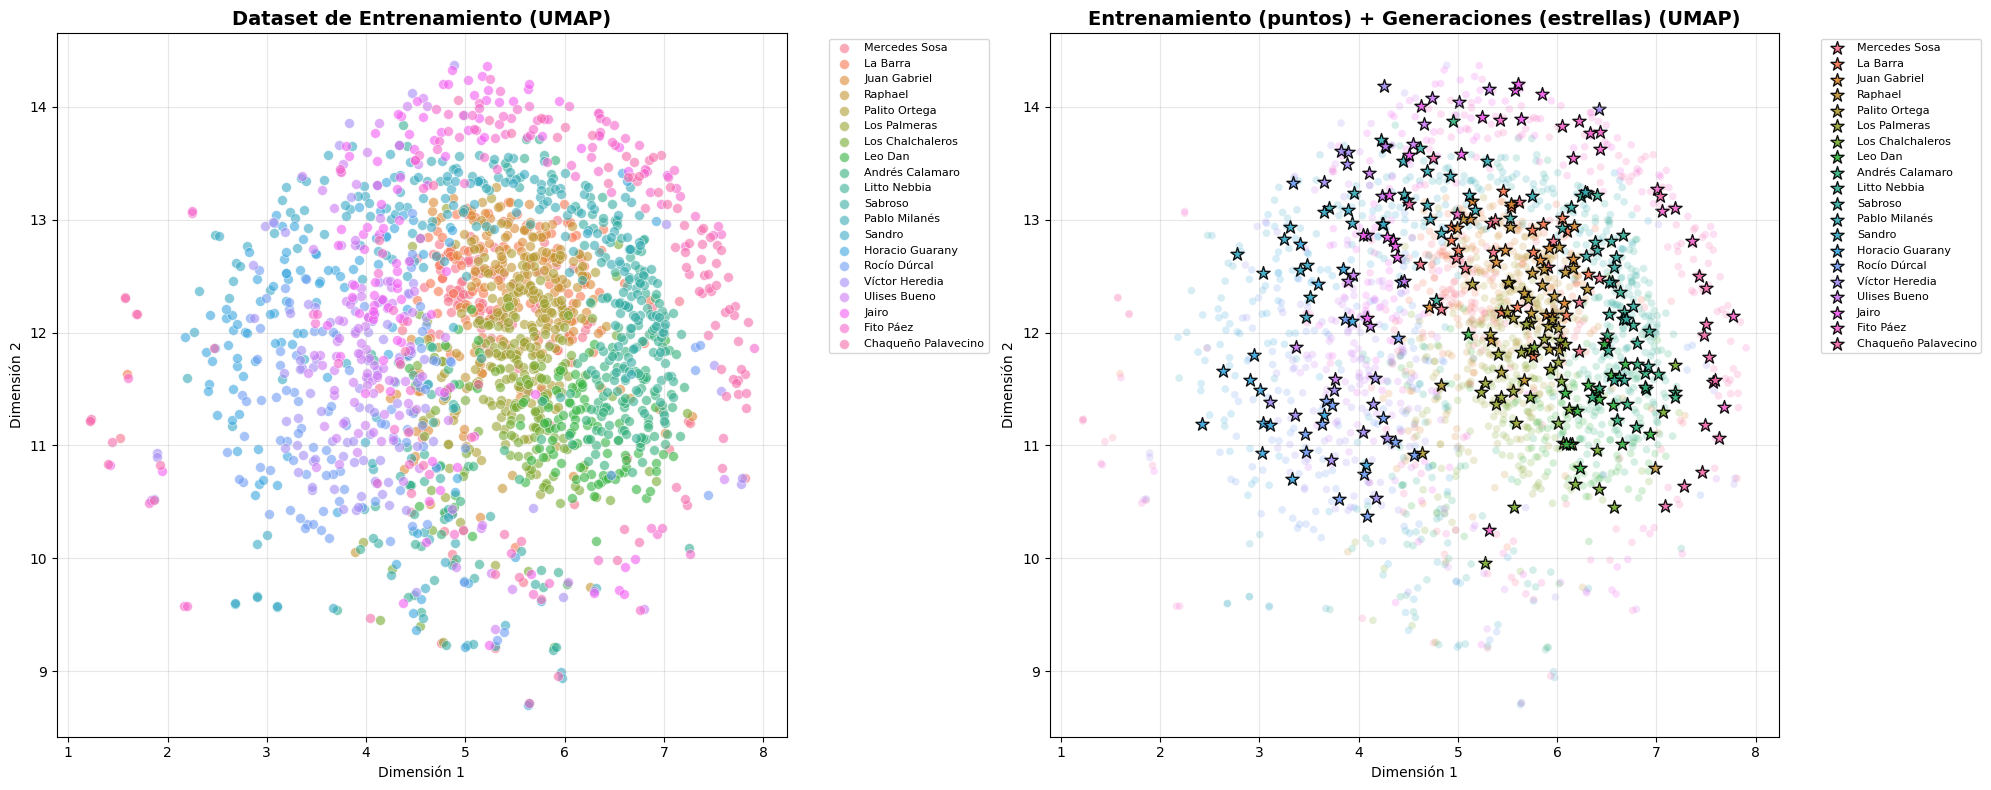

In [13]:
plotear_train_y_gen(X_2d, all_labels, all_types, artist_names)

El gráfico permite distinguir que hay zonas diferentes, pero se solapan un poco. Entonces, se calcula el centroide de cada Artista y se miden las distancias entre cada uno de ellos, para luego determinar los que estén mas separados entre ellos.

In [14]:
analisis_de_separacion(X_2d, all_labels, all_types, artist_names)


ANÁLISIS DE SEPARACIÓN
Distancia promedio INTRA-artista: 1.4166
Distancia promedio INTER-artista: 2.0369
Ratio de separación (inter/intra): 1.4379

Interpretación:
⚠️ Separación DÉBIL (ratio 1.2-1.5)
   Hay cierta agrupación pero con mucho solapamiento



MATRIZ DE DISTANCIAS ENTRE ARTISTAS (UMAP)
Centroides calculados para 20 artistas

------------------------------------------------------------
TOP 5 PARES MÁS CERCANOS (más similares):
------------------------------------------------------------
  La Barra                  ↔ Pablo Milanés            : 0.11
  Sabroso                   ↔ Chaqueño Palavecino      : 0.15
  Juan Gabriel              ↔ Palito Ortega            : 0.16
  Juan Gabriel              ↔ Raphael                  : 0.16
  Raphael                   ↔ Palito Ortega            : 0.16

------------------------------------------------------------
TOP 5 PARES MÁS LEJANOS (más diferentes):
------------------------------------------------------------
  Litto Nebbia              ↔ Horacio Guarany          : 2.49
  Leo Dan                   ↔ Horacio Guarany          : 2.51
  Andrés Calamaro           ↔ Sandro                   : 2.54
  Sabroso                   ↔ Horacio Guarany          : 2.60
  Andrés Calamaro           ↔

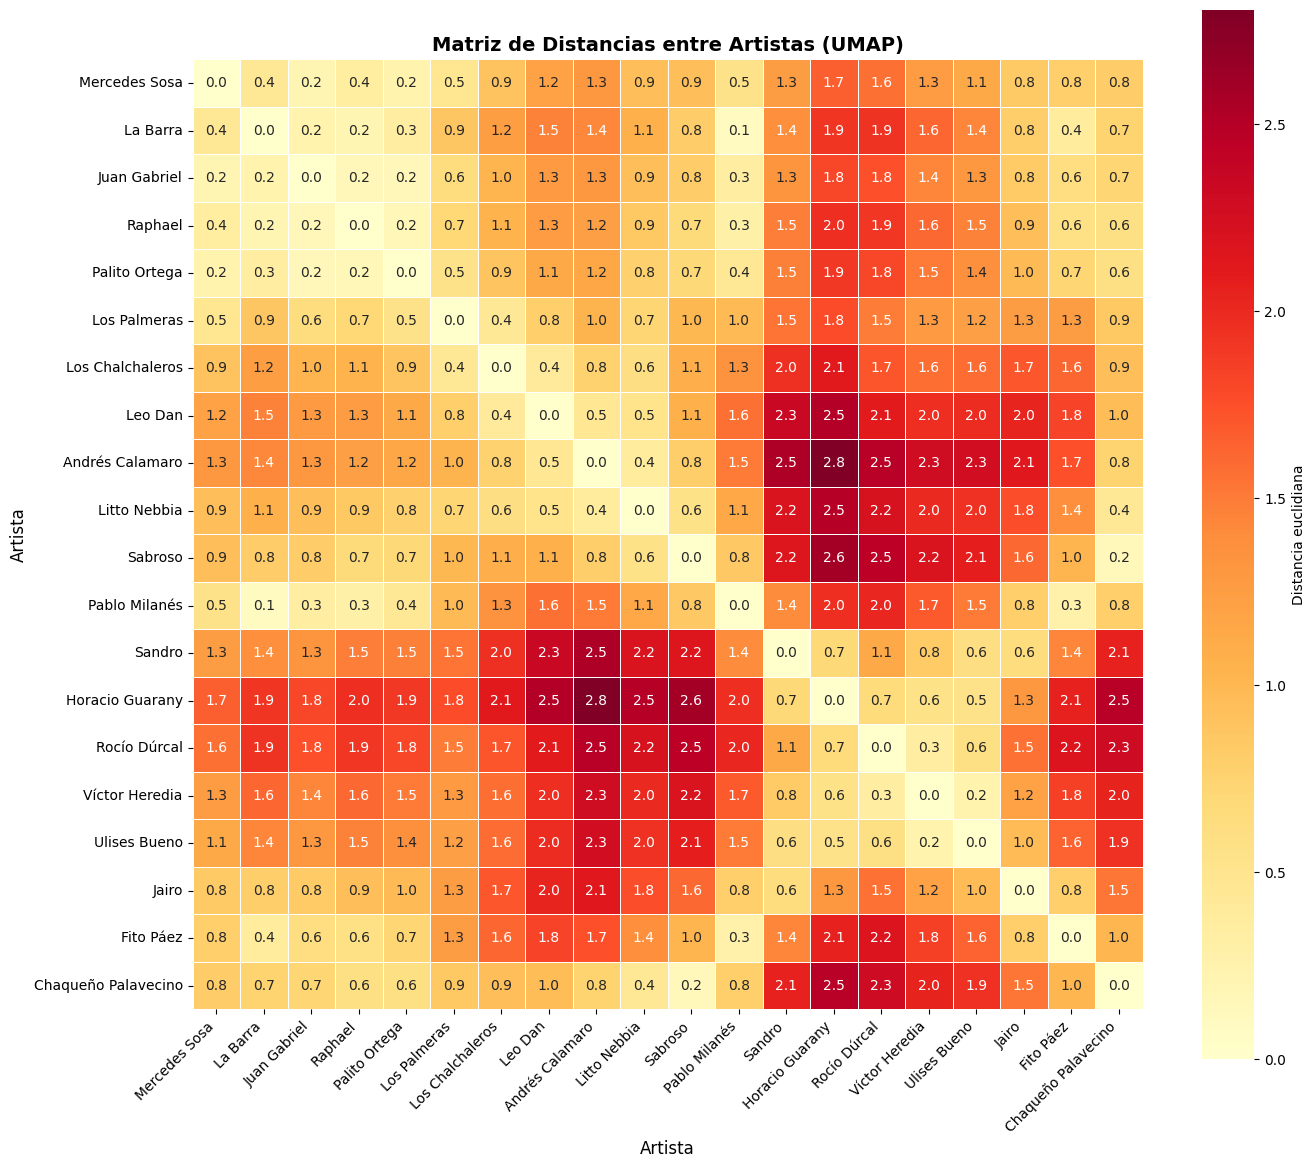


------------------------------------------------------------
ANÁLISIS DE AGRUPACIÓN NATURAL:
------------------------------------------------------------
✓ Coeficiente de variación ACEPTABLE (>0.30)
   Hay variación significativa en distancias
   Puede haber agrupaciones naturales



In [15]:
df_distances = distancias_entre_artistas(X_2d, all_labels, all_types, artist_names)

In [16]:
print("SELECCIÓN ÓPTIMA DE ARTISTAS DIFERENCIADOS")

selected = select_most_differentiated_artists(df_distances, n_artists=5)

# Calcular métricas del subset
subset_distances = []
for i, a1 in enumerate(selected):
    for j, a2 in enumerate(selected):
        if i < j:
            subset_distances.append(df_distances.loc[a1, a2])

avg_dist = np.mean(subset_distances)
min_dist = np.min(subset_distances)

print(f"Distancia promedio entre seleccionados: {avg_dist:.2f}")
print(f"Distancia mínima (cuello de botella): {min_dist:.2f}")
print(f"Artistas: {selected}")

SELECCIÓN ÓPTIMA DE ARTISTAS DIFERENCIADOS
Artista inicial (más diferenciado globalmente): Horacio Guarany
  + Andrés Calamaro (distancia mínima a seleccionados: 2.81)
  + Fito Páez (distancia mínima a seleccionados: 1.75)
  + Los Palmeras (distancia mínima a seleccionados: 1.04)
  + Sabroso (distancia mínima a seleccionados: 0.81)
Distancia promedio entre seleccionados: 1.61
Distancia mínima (cuello de botella): 0.81
Artistas: ['Horacio Guarany', 'Andrés Calamaro', 'Fito Páez', 'Los Palmeras', 'Sabroso']


In [17]:
# Del análisis de arriba, observo los artistas mas distantes:
SELECTED_ARTISTS = selected
print(selected)

['Horacio Guarany', 'Andrés Calamaro', 'Fito Páez', 'Los Palmeras', 'Sabroso']


In [18]:
artist_names = SELECTED_ARTISTS

## Seleccionados

Volvemos a graficar pero solo para los artistas más distantes entre ellos

In [19]:
training_data_filtered = {artist: training_data[artist] for artist in artist_names}
generation_data_filtered = {artist: generation_data[artist] for artist in artist_names}

X_filtered, all_texts_filtered, all_labels_filtered, all_types_filtered, vectorizer_filtered = prepararDatosParaVectorizacion(artist_names, training_data_filtered, generation_data_filtered)
X_2d_filtered, reducer_filtered = apply_umap(X_filtered)


Preparando datos (sample_size=100 por artista)...
Total documentos: 575
  - Entrenamiento: 500
  - Generaciones: 75



Vectorizando con TF-IDF...
Matriz TF-IDF: (575, 5000) (Total documentos, features)


Aplicando reducción de dimensionalidad con UMAP


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completado. Shape: (575, 2)



Generando visualización...

✓ Gráfico guardado: visualizacion_artistas.png


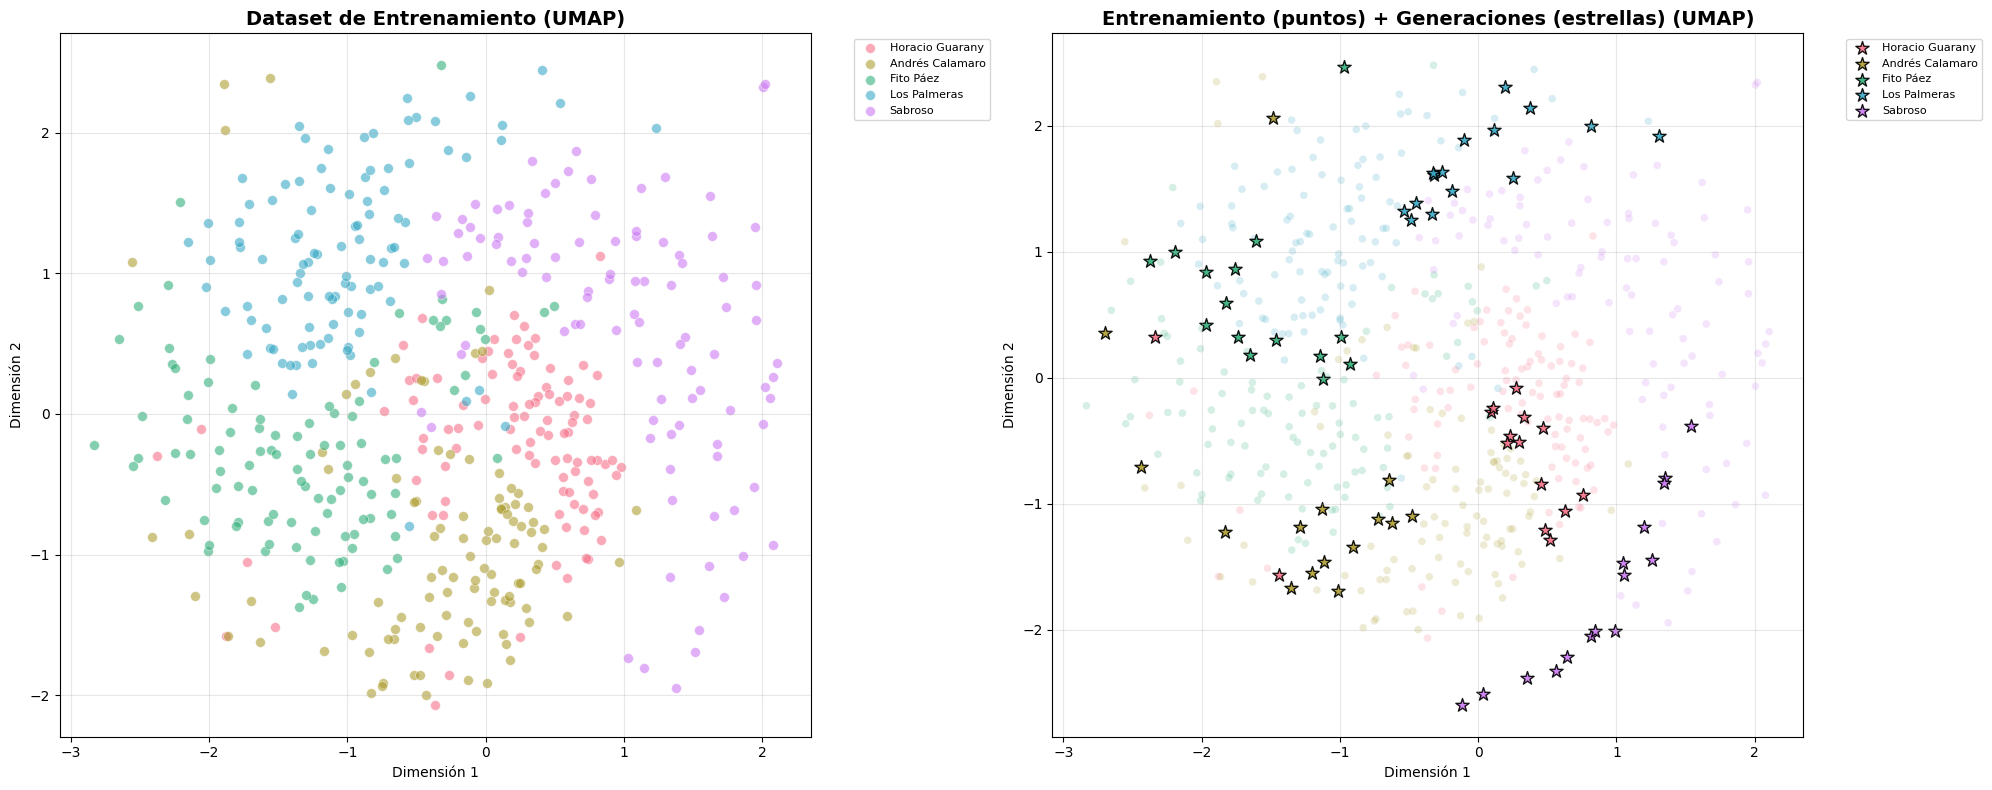

In [20]:
plotear_train_y_gen(X_2d=X_2d_filtered, all_labels=all_labels_filtered, all_types=all_types_filtered, artist_names=artist_names)